In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import spacy
import re
import nltk
from nltk.util import bigrams, trigrams
from nltk.corpus import stopwords
from helpers import load_datasets
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/stoffregen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
english_data, french_data = load_datasets(fraction=0.1)

In [3]:
# Functions to tokenize data and build vocab
spacy_fr = spacy.load('fr_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

def tokenize_fr(text):
    return [tok.text for tok in spacy_fr.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

def build_vocab(sentences, word_tokenizer):
    all_tokens = [word for sentence in sentences for word in word_tokenizer(sentence)]
    # Create a Counter object to count unique tokens
    vocabulary = Counter(all_tokens)
    return vocabulary

In [4]:
# Build vocabularies for English and French and determine their sizes
data_en = english_data["text"]
data_fr = french_data["text"]

# Build vocabularies
vocab_en = build_vocab(data_en, tokenize_en)
vocab_fr = build_vocab(data_fr, tokenize_fr)

# Get the size of each vocabulary
vocab_size_en = len(vocab_en)
vocab_size_fr = len(vocab_fr)

print(f"English Vocabulary Size: {vocab_size_en}")
print(f"French Vocabulary Size: {vocab_size_fr}")

English Vocabulary Size: 46811
French Vocabulary Size: 61020


In [5]:
# Average difference between sentence length and word length in English and French

def get_average_length_difference(source,target):
    avg_sentence_length_source = 0
    avg_sentence_length_target = 0
    word_length_dif=[]
    sentence_length_dif= []
    for sen_source, sen_target in zip(source["text"],target["text"]):
        #print(sen_source)
        avg_sentence_length_source += len(sen_source)
        avg_sentence_length_target += len(sen_target)
        sentence_length_dif.append(abs(len(sen_source)- len(sen_target)))
        word_length_dif.append(abs(np.mean([len(word) for word in sen_source.split(" ")])-np.mean([len(word) for word in sen_target.split(" ")])))
    print(f"Average sentence length in source: {avg_sentence_length_source/len(source)}")
    print(f"Average sentence length in target: {avg_sentence_length_target/len(target)}")
    print(f"Average sentence length difference: {np.mean(sentence_length_dif)}")
    print(f"Average word length difference: {np.mean(word_length_dif)}")

get_average_length_difference(english_data,french_data)


Average sentence length in source: 148.82285876516644
Average sentence length in target: 165.96126451895682
Average sentence length difference: 22.736746159823085
Average word length difference: 0.6696841197194036


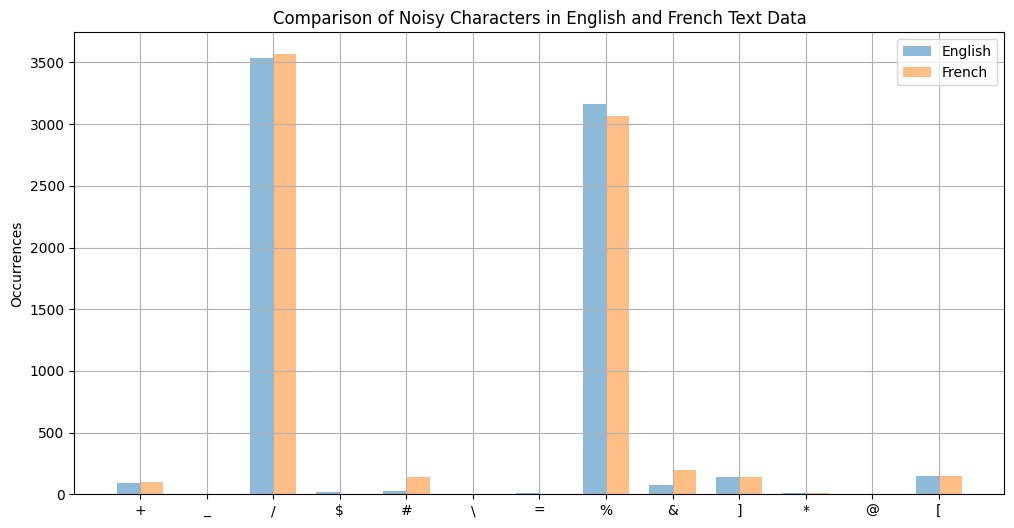

In [6]:


def overlay_noisy_character_counts(data_en, data_fr):
    # Define the characters to remove
    noisy_characters = re.escape('@#$%^&*~<>|\\{}[]+=_/')
    
    # Regex to match any noisy character
    regex_pattern = f'[{noisy_characters}]'
    
    # Function to count characters in a dataframe
    def count_characters(data):
        character_counts = Counter()
        for text in data['text']:
            found_chars = re.findall(regex_pattern, text)
            character_counts.update(found_chars)
        return character_counts

    # Count characters for both datasets
    en_counts = count_characters(data_en)
    fr_counts = count_characters(data_fr)

    # Plotting the occurrences for both English and French data in one overlaid histogram
    plt.figure(figsize=(12, 6))
    labels, en_values = zip(*en_counts.items())  # Unpack keys and values for English
    _, fr_values = zip(*fr_counts.items())      # Unpack values for French
    
    # Ensure both languages have entries for each label
    labels = list(set(labels + tuple(fr_counts.keys())))
    en_values = [en_counts.get(label, 0) for label in labels]
    fr_values = [fr_counts.get(label, 0) for label in labels]

    # Plot
    indices = np.arange(len(labels))  # the x locations for the groups
    width = 0.35                     # the width of the bars
    
    plt.bar(indices - width/2, en_values, width, label='English', alpha=0.5)
    plt.bar(indices + width/2, fr_values, width, label='French', alpha=0.5)

    plt.ylabel('Occurrences')
    plt.title('Comparison of Noisy Characters in English and French Text Data')
    plt.xticks(indices, labels)
    plt.legend()
    plt.grid(True)

    # save to figures
    plt.savefig('reports/figures/noisy_characters.png')
    plt.show()

    return en_counts, fr_counts

en_noisy_character_counts, fr_noisy_character_counts = overlay_noisy_character_counts(english_data, french_data)


English average token count: 27.976849361464748
French average token count: 30.622870719024565
English average sentence length in letters: 148.82285876516644
French average sentence length in letters: 165.96126451895682


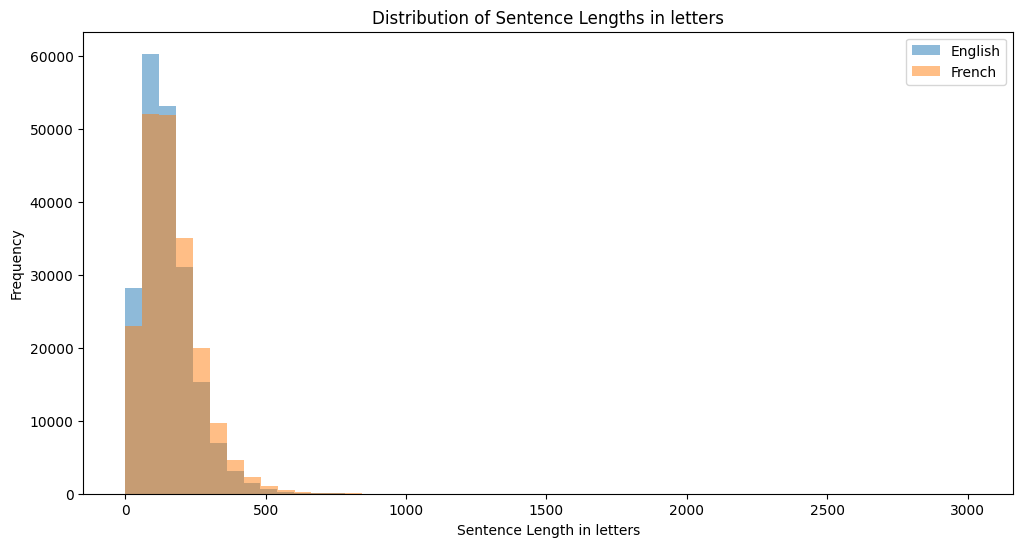

In [7]:


# Adding word count and sentence length columns
english_data['token_count'] = english_data['text'].apply(lambda x: len(tokenize_en(x)))
french_data['token_count'] = french_data['text'].apply(lambda x: len(tokenize_fr(x)))

english_data['sentence_length_in_letters'] = english_data['text'].apply(len)
french_data['sentence_length_in_letters'] = french_data['text'].apply(len)

# Basic statistics
print("English average token count:", english_data['token_count'].mean())
print("French average token count:", french_data['token_count'].mean())
print("English average sentence length in letters:", english_data['sentence_length_in_letters'].mean())
print("French average sentence length in letters:", french_data['sentence_length_in_letters'].mean())

# Histogram of sentence lengths
plt.figure(figsize=(12, 6))
plt.hist(english_data['sentence_length_in_letters'], bins=50, alpha=0.5, label='English')
plt.hist(french_data['sentence_length_in_letters'], bins=50, alpha=0.5, label='French')
plt.title('Distribution of Sentence Lengths in letters')
plt.xlabel('Sentence Length in letters')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('reports/figures/sentence_length.png')
plt.show()



Most common tokens in English:
[('the', 384890), (',', 267375), ('.', 197069), ('of', 182657), ('to', 169516), ('and', 144818), ('in', 121047), ('that', 92032), ('is', 85094), ('a', 85018)]
Most common tokens in French:
[('de', 291350), (',', 284608), ('.', 198647), ('la', 188648), ('et', 135155), ('le', 126533), ('les', 114401), ('à', 113220), ("l'", 108154), ('des', 105481)]


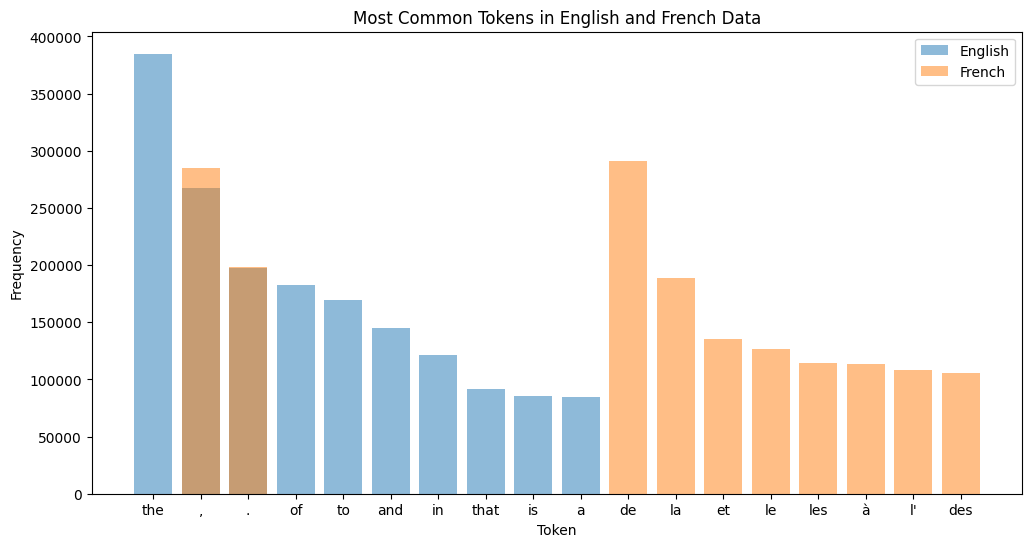

In [8]:
# Most common tokens
top_n = 10
english_tokens = Counter(word.lower() for sentence in english_data['text'] for word in tokenize_en(sentence))
french_tokens = Counter(word.lower() for sentence in french_data['text'] for word in tokenize_fr(sentence))

print("Most common tokens in English:")
print(english_tokens.most_common(top_n))

print("Most common tokens in French:")
print(french_tokens.most_common(top_n))

plt.figure(figsize=(12, 6))
plt.bar(*zip(*english_tokens.most_common(top_n)), alpha=0.5, label='English')
plt.bar(*zip(*french_tokens.most_common(top_n)), alpha=0.5, label='French')
plt.title('Most Common Tokens in English and French Data')
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('reports/figures/most_common_tokens.png')
plt.show()

In [24]:
# Stopwords setup
stopwords_en = set(stopwords.words('english'))
stopwords_fr = set(stopwords.words('french'))

def analyze_text(data, language, tokenizer, lng_stopwords):
    
    # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    data = data.copy()
    
    # Set text to lower
    print(f"Analyzing {language} data... Setting it to lowercase.")
    data['text'] = data['text'].apply(lambda x: x.lower())
    
    # Tokenization and removing punctuation
    print(f"Tokenizing {language} data...")
    data['tokenized'] = data['text'].apply(tokenizer)
    
    data['tokens'] = data['tokenized'].apply(lambda doc: [tok.text for tok in doc if tok.is_alpha])
    data['num_tokens'] = data['tokens'].apply(len)

    # Stopword analysis
    print(f"Analyzing stopwords in {language} data...")
    data['stopword_count'] = data['tokens'].apply(lambda tokens: sum(token in lng_stopwords for token in tokens))
    data['stopword_ratio'] = data['stopword_count'] / data['num_tokens']

    # Lexical diversity
    print(f"Calculating lexical diversity in {language} data...")
    data['lexical_diversity'] = data['tokens'].apply(lambda tokens: len(set(tokens)) / len(tokens) if tokens else 0)

    # N-Gram analysis
    print(f"Analyzing n-grams in {language} data...")
    data['bigrams'] = data['tokens'].apply(lambda tokens: list(bigrams(tokens)))
    data['trigrams'] = data['tokens'].apply(lambda tokens: list(trigrams(tokens)))

    # POS tagging
    print(f"Performing POS tagging in {language} data...")
    data['pos_tags'] = data['tokenized'].apply(lambda doc: [token.pos_ for token in doc if token.is_alpha])

    # Sentence complexity (count of clauses per sentence)
    print(f"Calculating sentence complexity in {language} data...")
    data['sentence_complexity'] = data['tokenized'].apply(lambda doc: sum(1 for token in doc if token.dep_ == 'conj'))

    return data


Analyzing English data... Setting it to lowercase.
Tokenizing English data...
Analyzing stopwords in English data...
Calculating lexical diversity in English data...
Analyzing n-grams in English data...
Performing POS tagging in English data...
Calculating sentence complexity in English data...


In [ ]:
# randomly sample 10% of the data to save on computation time
english_data_down_sampled = english_data.sample(frac=0.1, random_state=42)
french_data_down_sampled = french_data.sample(frac=0.1, random_state=42)
analyzed_english_data = analyze_text(english_data_down_sampled, 'English', spacy_en, stopwords_en)
analyzed_french_data = analyze_text(french_data_down_sampled, 'French', spacy_fr, stopwords_fr)

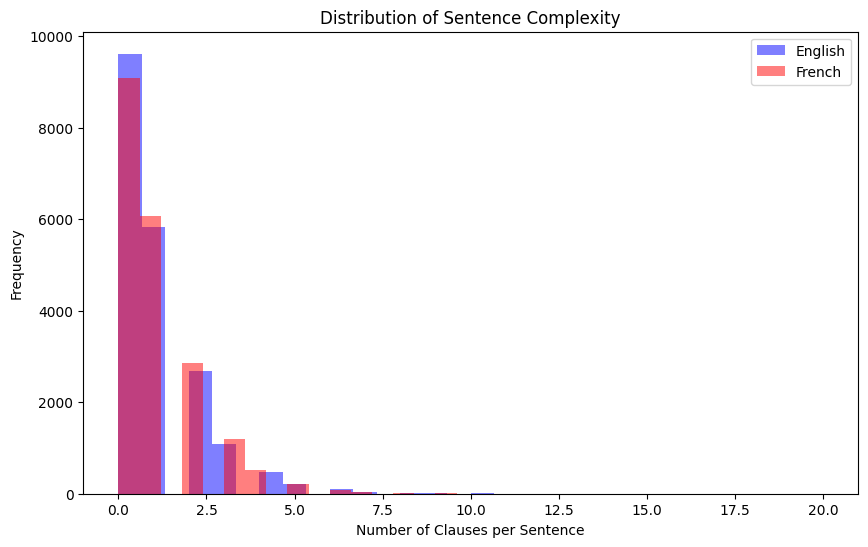

In [38]:
# Example output of analysis
#print("English sample analysis:")
#print(analyzed_english_data.head())
#print("French sample analysis:")
#print(analyzed_french_data[['lexical_diversity', 'stopword_ratio', 'sentence_complexity']].head())

# Visualization of sentence complexity
plt.figure(figsize=(10, 6))
plt.hist(analyzed_english_data['sentence_complexity'], bins=30, alpha=0.5, label='English', color='blue')
plt.hist(analyzed_french_data['sentence_complexity'], bins=30, alpha=0.5, label='French', color='red')
plt.title('Distribution of Sentence Complexity')
plt.xlabel('Number of Clauses per Sentence')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('reports/figures/sentence_complexity.png')
plt.show()